Clean makemore version -- doing what we did in class, but without all the learning notebooks. This is the clea version! Useful for learning & consolidation :P 


## Bigram Model (classic version)

In [1]:
import torch
words = open('names.txt', 'r').read().splitlines()

First, we wanna build the count matrix. So we'll start by adding in our special tokens and then counting the c1, c2s. 
Next, we want to convert our little count matrix into some probability distribution table (softmaxing it :P - exponentiate, normalise)
Then, we'll want to sample -- pick an initially random character, and follow the probability distribution trail.

Oh yeah, we also should integerise our chars so they're easier to work with, and so we can add the positions of those characters into our N matrix (also foreshadowing :o)

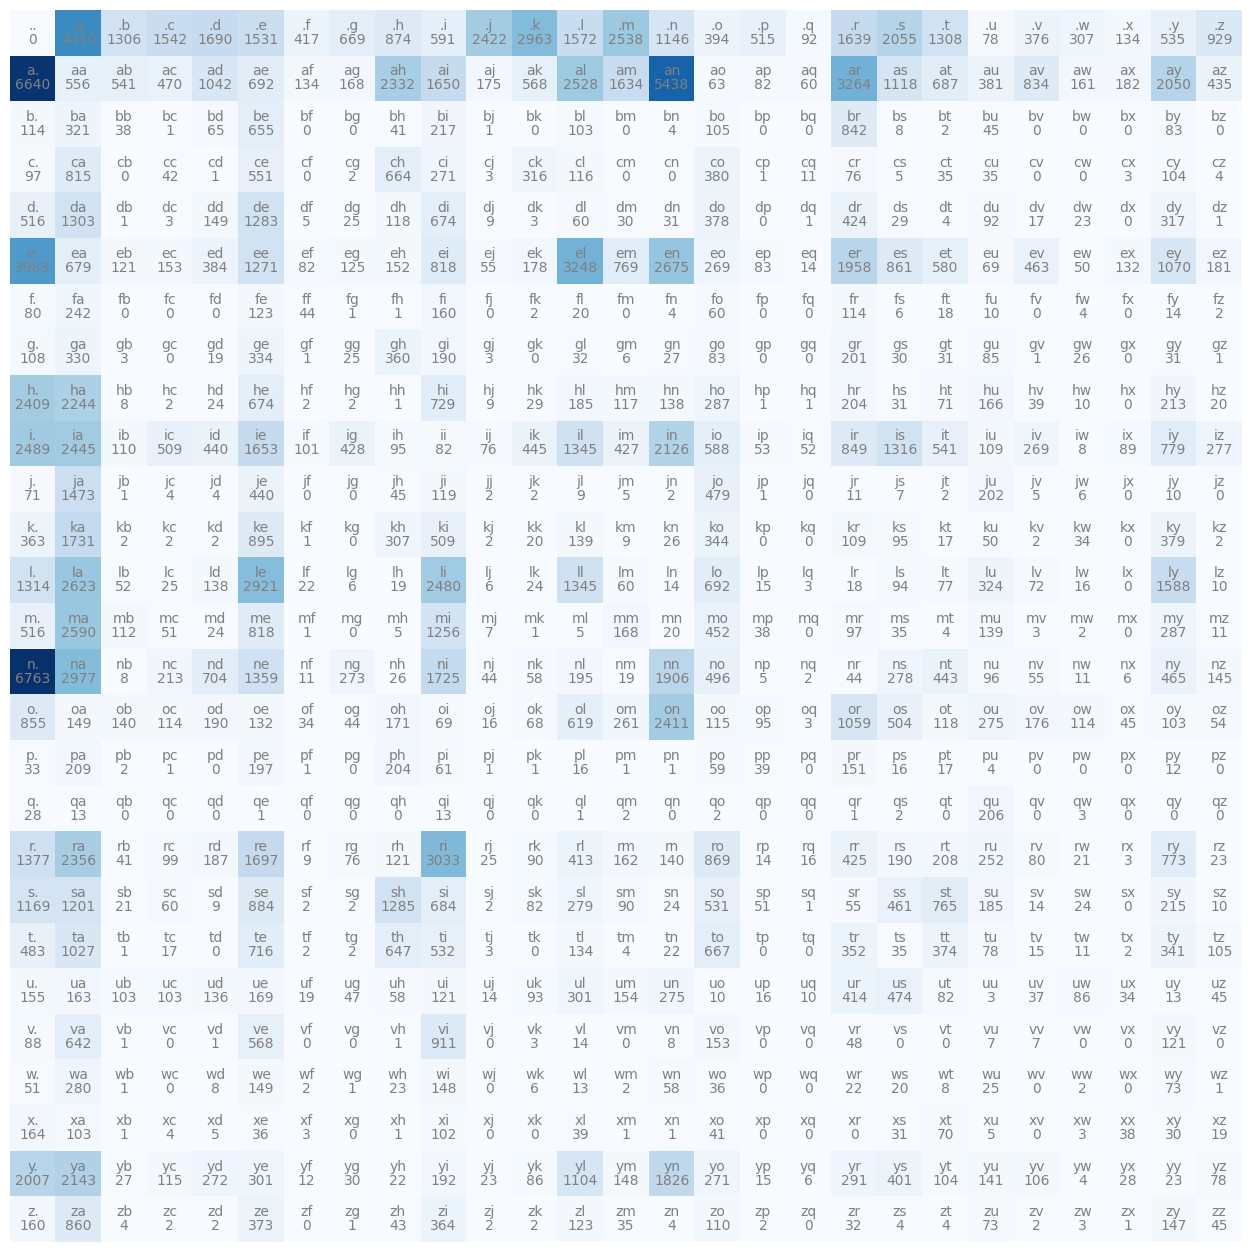

In [16]:
# Well, first we want to create the count matrix.
# Then we just do sampling. Of course, that means we need to convert our count matrix into some probability distribution, then pull from that. 
import matplotlib.pyplot as plt
%matplotlib inline
# Precursor stuff 
chars = list(sorted((set(''.join(words))))) # list a-z
string_to_int =  {s:i+1 for i,s in enumerate(chars)} # Btw, this is so weird lmao (in terms of being efficient) but I guess this is for generalisation, in case it wasn't just letters of the alphabet but something more.
string_to_int['.'] = 0
int_to_string =  {i:s for s, i in string_to_int.items()}

# Matrix init and counting part
N = torch.zeros((27, 27), dtype=torch.int32)
    
for w in words:
    chs =  ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # zip is so cool
        ix1 = string_to_int[ch1]
        ix2 = string_to_int[ch2]
        N[ix1, ix2] += 1 # this character set has occurred +1 times


### Lil function boi for matrix plot showing :o
def plot_count(matrix):
    # Plots matrix (used for N matrices)
    plt.figure(figsize=(16, 16))
    plt.imshow(matrix, cmap="Blues")
    for i in range(27):
        for j in range(27):
            chrstr = int_to_string[i] + int_to_string[j] # ab, aj, cl, ...
            plt.text(j, i, chrstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, matrix[i, j].item(), ha="center", va="top", color="gray") # .item() to get the int in the tensor element
    plt.axis('off')
plot_count(N)


mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


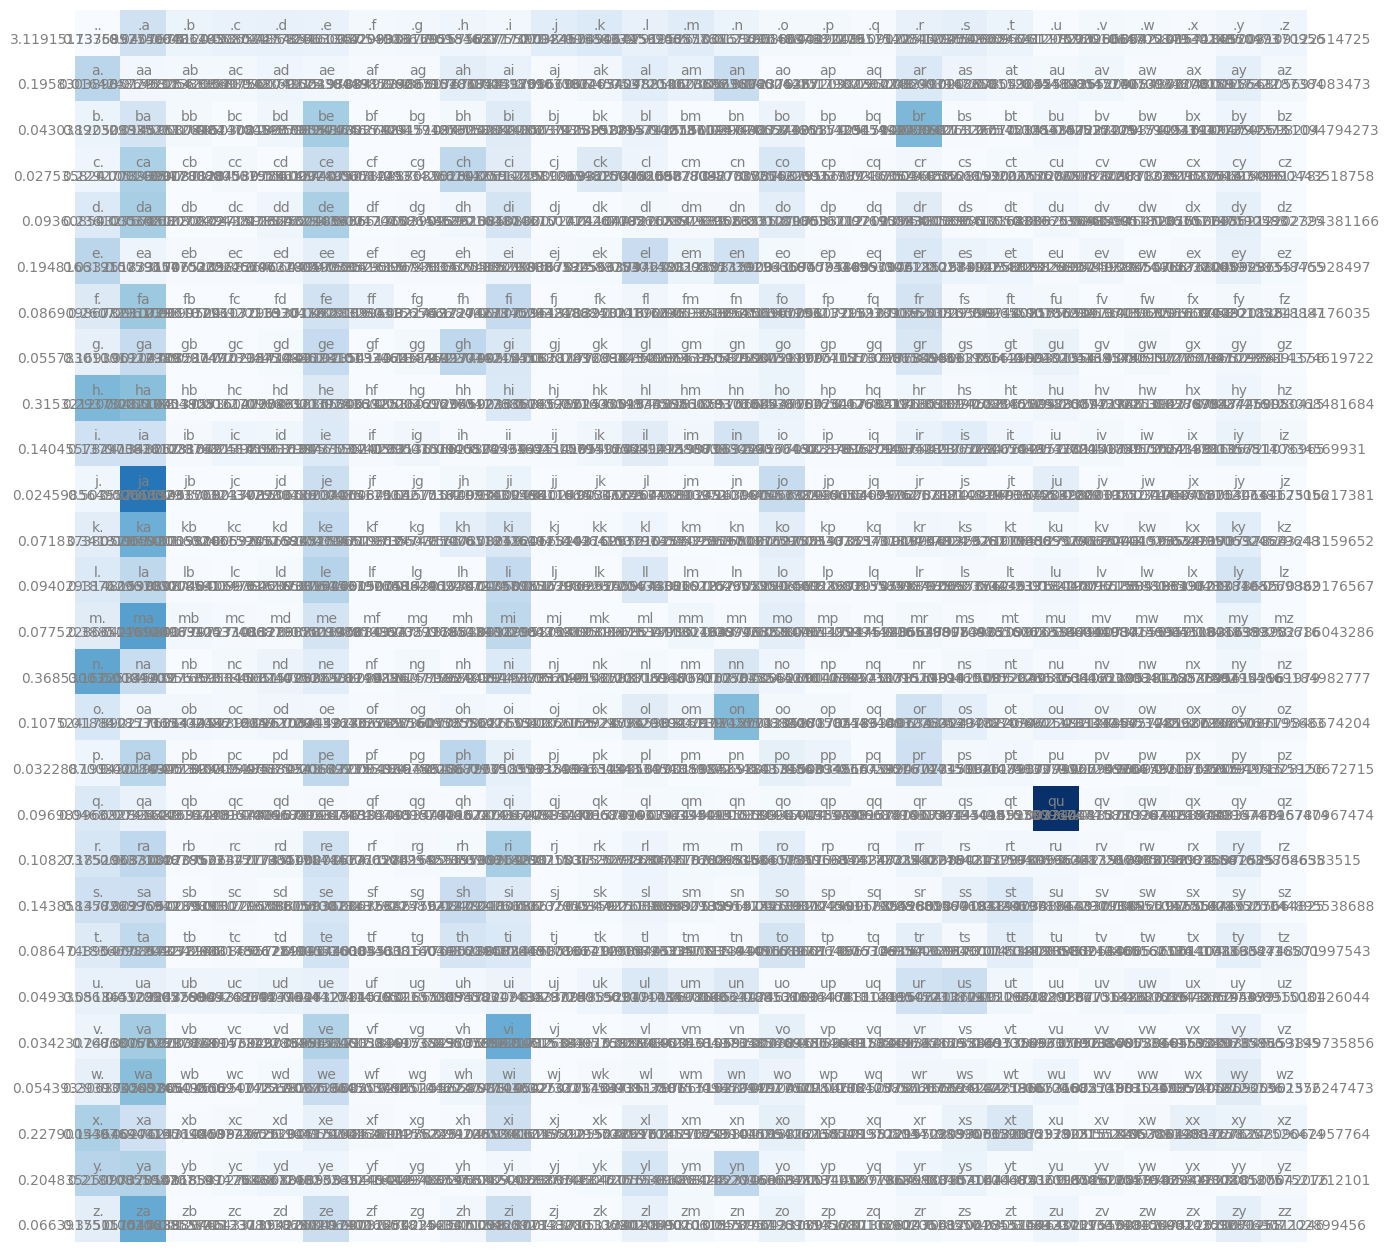

In [23]:
# Sampling 
g = torch.Generator().manual_seed(2147483647) # keeps the same 'randomness' generated
P = (N+1).float() # smooth +1 so we don't get 'inf' errors later
P /= P.sum(1, keepdim=True) # Normalise the distribution so it becomes a prob distribution.
assert P[0].sum() == 1 # SANITY CHECK, ELSE WE DID THE SUM WRONG. Each row is prob distribution of that row's next character.

# Sampling looop
for i in range(10):
    ix = 0
    out = []

    # keep sampling characters till end token spotted. Start by selecting character we're at, and its prob distribution
    # Then select index of the 2nd chosen char, that was selected via multinomial. Continue until end token reached.
    # Get the char of that integer rep, then add to our word thingy
    while True:  
        prob_dist = P[ix]
        ix = torch.multinomial(prob_dist, 1, replacement=True, generator=g).item() 

        out.append(int_to_string[ix])

        if ix == 0:
            break
    
    print(''.join(out))
# plot_count(P)


Great!  That's our bigram model!
Now, we'll evaluate it using the negative log likelihood :) -- loss function acquired!

In [24]:
log_likelihood = 0.0
n = 0


for w in words:
# for w in ["yuvraj"]: ## YOOO you can check it out with your own names n shit to find its probability :o 
    chs =  ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = string_to_int[ch1]
        ix2 = string_to_int[ch2]
        prob = P[ix1, ix2] 
        logprob = torch.log(prob) # log because the prob numbers will be absurdly small if we product them together.
        log_likelihood += logprob # Log likelihood, logprob range is -inf -> 0 and we can add logprobs instead of multiplying probs (nicer number to look at!)
        n +=1
        # print(f"{ch1}{ch2}: {prob:.4f}, {logprob:.4f}")

print(f'{log_likelihood=}')
nll = -log_likelihood # a very nice loss function -- lowest it gets is 0. Higher it is, worse off the predictions are
print(f'{nll=}') # summed nll
print(f'{nll/n=}') # averaged log likelihood basically -- usually the loss function as the number is nicer.


log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
nll/n=tensor(2.4544)


Hurray, we have our loss function now!
## Time to implement a bigram neural network :o 

In [50]:
# Dataset manipulation
import torch.nn.functional as F

# Create training set of bigrams
xs, ys = [], [] # Bigram labels. given xs, label ys. Ofc, we want these in integers so we convert char -> int below
for w in words:
    chs = ['.'] + list(w) + ['.'] # Adding special token
    # print(list(zip(chs, chs[1:]))) # DON'T UNPRINT THIS WITHOUT CAPPING OFF THE WORDS to like words[:3]
    
    for ch1, ch2 in zip(chs, chs[1:]): # zip makes 'emma' -> '(e,m),(m,m),(m,a)'.  Ofc we have special tokens too so it different.
        ix1 = string_to_int[ch1]
        ix2 = string_to_int[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs) # convert to tensor
ys = torch.tensor(ys) 
num = xs.nelement()
print('number of examples: ', num)

# generate weights
g = torch.Generator().manual_seed(2147483647) 
W = torch.randn((27,27), generator=g, requires_grad = True)



number of examples:  228146


In [51]:
# Now onto the model stuff, gradient descent, very cool
### We are going to encode the xs via one-hot encoding so we don't have larger chars/indices -> larger weight influence

for i in range(100):
    # Forward pass - get nn output, convert to prob dist via softmax, get loss
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    # print(probs.shape)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())

    # Backward pass - zero the grads, pass it bback
    W.grad = None
    loss.backward()


    #Update weights 
    W.data += -50* W.grad


3.768618583679199
3.378786325454712
3.1610782146453857
3.027181386947632
2.9344804286956787
2.8672285079956055
2.816652774810791
2.777146100997925
2.745253562927246
2.7188305854797363
2.6965057849884033
2.677372694015503
2.6608054637908936
2.6463515758514404
2.6336653232574463
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794439315796
2.5886809825897217
2.5822560787200928
2.5764293670654297
2.5711233615875244
2.566272497177124
2.5618226528167725
2.5577263832092285
2.5539441108703613
2.550442695617676
2.5471925735473633
2.5441696643829346
2.5413525104522705
2.538722038269043
2.536261796951294
2.5339584350585938
2.531797409057617
2.5297679901123047
2.527860164642334
2.5260636806488037
2.5243704319000244
2.522773265838623
2.52126407623291
2.519836902618408
2.5184857845306396
2.5172054767608643
2.515990972518921
2.5148370265960693
2.5137407779693604
2.512697696685791
2.511704921722412
2.5107581615448
2.509854793548584
2.5089921951293945
2.5081686973571777
2.507380247116089
2

In [52]:
## Sampling
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float() # encode your char to vector 
    logits = xenc @ W # predict log-counts; in this case, it's legit just getting the ix'th row of W  
    counts = logits.exp() # counts, equivalent to N matrix
    # plt.imshow(counts.data)
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # print(p.shape)
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(int_to_string[ix])
    if ix == 0:
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondmaisah.
anchthizarie.
